# GLM: Negative Binomial Regression

This notebook demos negative binomial regression using the `glm` library. It essentially replicates the GLM Poisson regression example by [Jonathan Sedar](https://github.com/jonsedar) (which is in turn insipired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/)) except with data is negative binomially distributed instead of Poisson distributed.

Negative binomial regression is useful for modeling count data for which the variance is higher than the mean. The [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so it has a free parameter to control for the increased variance.

In [147]:
import sys, os
sys.path.insert(0, '/Users/jonathanf/pymc3')

import numpy as np
from numpy.random import negative_binomial
from scipy import stats
import pandas as pd
import pymc3 as pm
import re
import patsy as pt
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Generate Data

As in the Poisson regression example, we assume that sneezing occurs at some baseline rate, and that consuming alcohol, not taking antihistamines, or doing both, increase its frequency.

In [250]:
np.random.seed(123)

# Mean values and rate parameter
mu_noalcohol_meds = 1    # no alcohol, took an antihistamine
mu_alcohol_meds = 2  # alcohol, took an antihistamine
mu_noalcohol_nomeds = 4  # no alcohol, no antihistamine
mu_alcohol_nomeds = 16   # alcohol, no antihistamine
alpha = 20

def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu`,
    then drawing from a Poisson distribution whose rate parameter
    is given by the gamma sample.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)


# Create samples
n = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((get_nb_vals(mu_noalcohol_meds, alpha, n),
                                   get_nb_vals(mu_alcohol_meds, alpha, n),
                                   get_nb_vals(mu_noalcohol_nomeds, alpha, n),
                                   get_nb_vals(mu_alcohol_nomeds, alpha, n))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

### Visualize and summarize the data

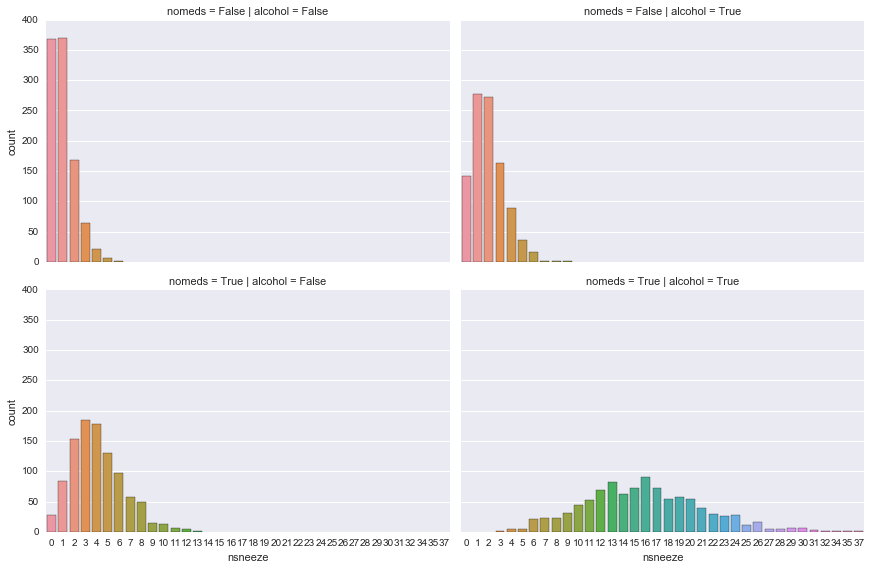

In [236]:
sns.factorplot(x='nsneeze', row='nomeds', col='alcohol', data=df, kind='count', aspect=1.5);

In [237]:
df.groupby(['nomeds', 'alcohol'])['nsneeze'].agg(['mean', 'var'])

mean        var
nomeds alcohol                   
False  False     1.025   1.119494
       True      1.969   2.056095
True   False     4.077   5.304375
       True     15.840  28.450851

As in the Poisson regression example, we see that drinking alcohol and/or not taking antihistamines increase the sneezing rate to varying degrees. Unlike in that example, for each combination of `alcohol` and `nomeds`, the variance of `nsneeze` is higher than the mean. This suggests that a Poisson distrubution would be a poor fit for the data since the mean and variance of a Poisson distribution are equal.

In [244]:
def plot_traces(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
        
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

## Negative Binomial Regression

In [265]:
fml = 'nsneeze ~ alcohol + nomeds + alcohol:nomeds'

with pm.Model() as model:
    pm.glm.glm(formula=fml, data=df, family=pm.glm.families.NegativeBinomial())
    
    # This initialization seems to improve mixing
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    C = pm.approx_hessian(start)
    trace = pm.sample(4000, step=pm.NUTS(scaling=C))

Optimization terminated successfully.
         Current function value: 8390.165688
         Iterations: 13
         Function evaluations: 908


100%|██████████| 4000/4000 [00:54<00:00, 73.61it/s] 


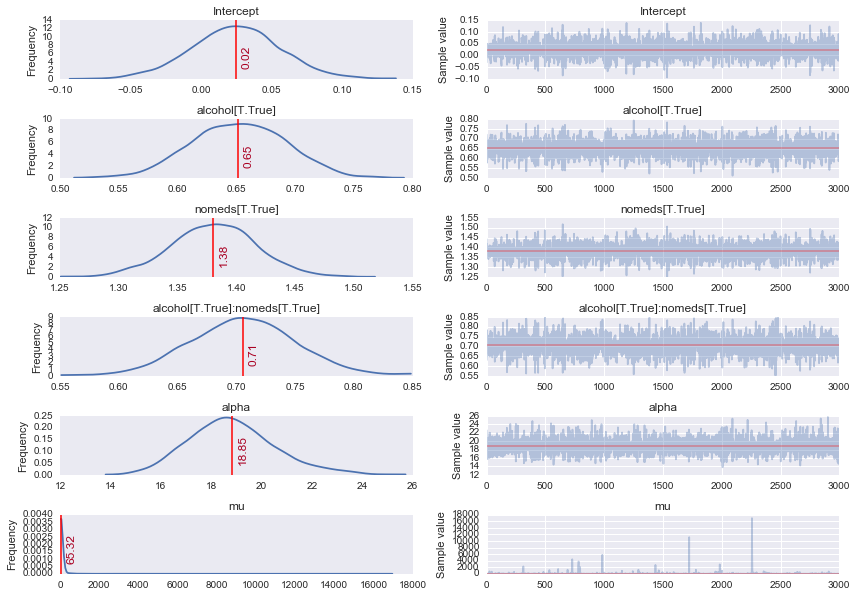

In [266]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace[1000:], varnames=rvs);

In [253]:
# Transform coefficients to recover parameter values
np.exp(pm.df_summary(trace[1000:], varnames=rvs)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
Intercept,1.023988e+00,9.629458e-01,1.097553e+00
alcohol[T.True],1.922046e+00,1.765878e+00,2.078478e+00
nomeds[T.True],3.980620e+00,3.693002e+00,4.252625e+00
alcohol[T.True]:nomeds[T.True],2.021802e+00,1.846852e+00,2.202873e+00
alpha,1.513678e+08,7.033976e+06,4.531350e+09
mu,7.260115e+24,1.002149e+00,5.609641e+70


The mean values are very close to the values we specified when generating the data:
    - Base rate is 1.
    - Drinking alcohol doubles the base rate.
    - Not taking antihistamines quadruples the base rate.
    - Drinking alcohol and not taking antihistamines doubles the rate that would be expected if their rates were independent. If they were independent, then doing both would increase the base rate by 2*4=8 times, but instead the base rate is increased by 2*4*2=16 times.

In [267]:
np.percentile(trace[-1000:]['mu'], [25,50,75])

array([  4.54109029,  10.31667585,  23.97320375])

In [268]:
df.nsneeze.mean()

5.7277500000000003